In [1]:
# common
import os
import random
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi
from sklearn.model_selection import train_test_split
import shutil
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
#cv2
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
# Data
# from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt
# Model 
from keras.models import Model
from keras.layers import Layer,Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate,Conv2DTranspose
from keras.layers import BatchNormalization,MaxPool2D,Multiply,Add,ReLU

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
# from tf_explain.core.grad_cam import GradCAM
# Metrics
from keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam

## Load the breast images and their corresponding segmentation masks:

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/cv_project/Breast_scans.zip

Archive:  /content/gdrive/MyDrive/cv_project/Breast_scans.zip
   creating: Breast scans/
   creating: Breast scans/benign/
   creating: Breast scans/benign/Test/
  inflating: Breast scans/benign/Test/benign (398)_mask.png  
  inflating: Breast scans/benign/Test/benign (399).png  
  inflating: Breast scans/benign/Test/benign (399)_mask.png  
  inflating: Breast scans/benign/Test/benign (400).png  
  inflating: Breast scans/benign/Test/benign (400)_mask.png  
  inflating: Breast scans/benign/Test/benign (401).png  
  inflating: Breast scans/benign/Test/benign (401)_mask.png  
  inflating: Breast scans/benign/Test/benign (402).png  
  inflating: Breast scans/benign/Test/benign (402)_mask.png  
  inflating: Breast scans/benign/Test/benign (403).png  
  inflating: Breast scans/benign/Test/benign (403)_mask.png  
  inflating: Breast scans/benign/Test/benign (404).png  
  inflating: Breast scans/benign/Test/benign (404)_mask.png  
  inflating: Breast scans/benign/Test/benign (405).png  
  inf

In [ ]:
# Define a function to display an image
def show_image(image, title=None, cmap=None, alpha=1):
    # Display the image with optional arguments for color map and transparency
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    # Turn off the axis labels and ticks for a cleaner display
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.5):
    plt.imshow(image)
    # Display the mask overlaid on the image using TensorFlow's "squeeze" function to remove dimensions of size 1
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')


In [ ]:
from matplotlib.colors import ListedColormap
cmap = plt.cm.get_cmap('jet')  # Choose any colormap you like
newcolors = cmap(np.linspace(0, 1, cmap.N))
white = np.array([1, 1, 1, 1])
newcolors[0, :] = white  # Set the first color to white
newcmap = ListedColormap(newcolors)
red = [1, 0, 0, 1] 
# Define the colors
red = [1, 0, 0, 1]     # RGBA values for red
green = [0, 1, 0, 1]   # RGBA values for green
white = [1, 1, 1, 0]   # RGBA values for transparent white

# Create an array of colors
newcolors = np.array([white, green ,red])

# Create a colormap object
newcmap = ListedColormap(newcolors)


In [ ]:
SIZE = 256
# Define model training parameters
batch_size = 16
epochs = 50
lr = 1e-4

In [ ]:
# Define function to load and resize an image
def load_image(image, SIZE):
    # Load the image, convert it to an array, and resize it
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

# Define function to load and resize multiple images
def load_images(image_paths, SIZE, mask=False, trim=None, double_mask = None):
    # If a trim value is provided, limit the number of images to load
    if trim is not None:
        image_paths = image_paths[:trim]
    
    # Create an array to hold the images
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
      
    # Loop through each image and load it into the array
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    # Return the array of images
    return images


In [ ]:
# Define a function to extract mask paths from a given root path
def extract_masks_paths(root_path):
    # Get the names of all the classes (subfolders) in the root path
    classes = sorted(os.listdir(root_path))
    
    # Find all single masks (ending in "*mask.png") in the train and test subfolders for each class
    single_mask_paths = sorted([sorted(glob(root_path + name +"/Train" +  "/*mask.png")) for name in classes])
    single_mask_paths.extend(sorted([sorted(glob(root_path +name + "/Test" +  "/*mask.png")) for name in classes]))

    # Find all double masks (ending in "*mask_1.png") in the train and test subfolders for each class
    double_mask_paths = sorted([sorted(glob(root_path + name +"/Train"+ "/*mask_1.png")) for name in classes])
    double_mask_paths.extend(sorted([sorted(glob(root_path + name +"/Test" + "/*mask_1.png")) for name in classes]))

    # Return both the single and double mask paths
    return single_mask_paths, double_mask_paths


In [ ]:
# Define a function to flatten a list of lists
def flatten(single_mask_paths, double_mask_paths):
  # Use list comprehension to flatten the list of single masks
  flat_single_mask_paths = [elem for sublist in single_mask_paths for elem in sublist]
  # Use list comprehension to flatten the list of double masks
  flat_double_mask_paths = [elem for sublist in double_mask_paths for elem in sublist]
  # Return the flattened lists
  return flat_single_mask_paths, flat_double_mask_paths

In [ ]:
# define the function that takes flat_double_mask_paths as input
def merge_double_mask_img(flat_double_mask_paths):
  
  # initialize empty lists to store data
  masked_img = [] # to store final masked image
  mask1_paths = [] # to store paths of first mask
  double_img_paths = [] # to store paths of double images
  
  # loop through each path in flat_double_mask_paths
  for mask2_path in flat_double_mask_paths: 
    # create a numpy array of zeros with required shape
    img = np.zeros((1,SIZE,SIZE,3)) 
    # get the path of the first mask by replacing '_1' in the current path with empty string
    mask1_path = mask2_path.replace('_1','')
    # append the mask1_path to mask1_paths list
    mask1_paths.append(mask1_path)

    # get the path of the double image by replacing '_mask_1' in the current path with empty string
    img_path = mask2_path.replace('_mask_1','')
    # append the img_path to double_img_paths list
    double_img_paths.append(img_path)
    
    # load the first and second mask images using load_image function with SIZE parameter
    mask1 = load_image(mask1_path , SIZE)
    mask2 = load_image(mask2_path, SIZE)

    # add both masks and store the result in img variable
    img = img + mask1 + mask2
    
    # reshape img to remove unnecessary dimensions and store it back in img variable
    img = img[0,:,:,0]  
    img = img.reshape(img.shape[0],img.shape[1],1)
    
    # append img to masked_img list
    masked_img.append(img) 

  # return the final output in form of a tuple containing double_img_paths, mask1_paths, and masked_img
  return double_img_paths,mask1_paths,masked_img


In [ ]:
# define the function that takes flat_single_mask_paths as input
def single_mask_img(flat_single_mask_paths,mask1_paths):
  
  # initialize empty lists to store data
  image_paths = [] # to store paths of images
  mask_paths = [] # to store paths of masks
  
  # loop through each path in flat_single_mask_paths
  for class_path in flat_single_mask_paths:
    
    if class_path not in mask1_paths:
      # check if the current path is a specific image path and if it is, replace it with a different image path
      if class_path == 'Breast scans/benign/Test/benign (398)_mask.png':
        img_path = 'Breast scans/benign/Train/benign (398).png'
      else:
        img_path = class_path.replace('_mask','')

      # append the image and mask paths to their respective lists
      image_paths.append(img_path)
      mask_paths.append(class_path)

  # return the final output in form of a tuple containing image_paths and mask_paths
  return image_paths,mask_paths

In [ ]:
# call the function extract_masks_paths with 'Breast scans/' 
single_mask_paths, double_mask_paths = extract_masks_paths('Breast scans/')

# call the function flatten with single_mask_paths and double_mask_paths 
flat_single_mask_paths, flat_double_mask_paths = flatten(single_mask_paths, double_mask_paths)

# call the function merge_double_mask_img with flat_double_mask_paths 
double_img_paths, mask1_paths, masked_img = merge_double_mask_img(flat_double_mask_paths)

# call the function single_mask_img with flat_single_mask_paths 
image_paths, mask_paths = single_mask_img(flat_single_mask_paths,mask1_paths)


In [ ]:
# load and concatenate single and double masks with corresponding images
images = load_images(image_paths, SIZE)
double_images = load_images(double_img_paths, SIZE)
images = np.concatenate((images,double_images),axis=0)

masks = load_images(mask_paths, SIZE, mask=True)
double_masks = load_images(mask1_paths, SIZE, mask=True)
masks = np.concatenate((masks,double_masks),axis=0)

In [ ]:
print(images.shape)
print(masks.shape)

(648, 256, 256, 3)
(648, 256, 256, 1)


# New model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.05, random_state=42)

In [ ]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

615 615
33 33


In [ ]:
def dice_loss(y_true, y_pred):
    # Flatten the predictions and ground truth
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    
    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    
    return dice_loss

In [ ]:
def block_conv_down(x, dims):
    x = tf.keras.layers.Conv2D(
        dims,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(
        dims,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    p = tf.keras.layers.Dropout(0.2)(p)
    return x, p


def bottleneck(x, dims):
    x = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def block_conv_up(x, p, dims):
    p = tf.keras.layers.UpSampling2D(2)(p)
    u = tf.keras.layers.Concatenate(axis=-1)([p, x])

    u = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(u)
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.Activation("relu")(u)
    u = tf.keras.layers.Dropout(0.1)(u)

    u = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(u)
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.Activation("relu")(u)
    u = tf.keras.layers.Dropout(0.1)(u)

    return u


def UNET(input_shape):
    input = tf.keras.layers.Input(shape=input_shape)
    x1, p1 = block_conv_down(input, 64)
    # print(f" x1 shape : {x1.shape}")
    x2, p2 = block_conv_down(p1, 128)
    # print(f" x2 shape : {x2.shape}")
    x3, p3 = block_conv_down(p2, 256)
    # print(f" x3 shape : {x3.shape}")
    x4, p4 = block_conv_down(p3, 512)
    # print(f" x4 shape : {x4.shape}")

    p5 = bottleneck(p4, 1024)
    # print(f" p5 shape : {p5.shape}")
    p6 = block_conv_up(x4, p5, 512)
    # print(f" p6 shape : {p6.shape}")
    p7 = block_conv_up(x3, p6, 256)
    # print(f" p7 shape : {p7.shape}")
    p8 = block_conv_up(x2, p7, 128)
    # print(f" p8 shape : {p8.shape}")
    p9 = block_conv_up(x1, p8, 64)

    # print(f" p9 shape : {p9.shape}")

    output = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(p9)
    # output = tf.keras.layers.Conv2D(2,(1,1), activation = "softmax")
    model = tf.keras.Model(inputs=input, outputs=output)

    return model
    
model =UNET((256, 256, 3))

In [ ]:
model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy',dice_loss])

In [ ]:
# Define early stopping and reduce learning rate on plateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

In [ ]:
# Train the UNet model on the training data
history = model.fit(#dataset,
                    X_train, y_train,
                    batch_size=batch_size, epochs=epochs,

                    callbacks=[early_stop, reduce_lr],
                    validation_data=(X_test, y_test))

Epoch 1/50
39/39 [==============================] - 108s 2s/step - loss: 0.7026 - accuracy: 0.7129 - dice_loss: 0.7025 - val_loss: 0.7544 - val_accuracy: 0.8478 - val_dice_loss: 0.7313 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 45s 1s/step - loss: 0.6032 - accuracy: 0.8492 - dice_loss: 0.6011 - val_loss: 0.7907 - val_accuracy: 0.9229 - val_dice_loss: 0.7787 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 45s 1s/step - loss: 0.5557 - accuracy: 0.8911 - dice_loss: 0.5531 - val_loss: 0.7376 - val_accuracy: 0.6137 - val_dice_loss: 0.6977 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 45s 1s/step - loss: 0.5188 - accuracy: 0.9032 - dice_loss: 0.5166 - val_loss: 0.5798 - val_accuracy: 0.8976 - val_dice_loss: 0.4769 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 45s 1s/step - loss: 0.4981 - accuracy: 0.9159 - dice_loss: 0.4983 - val_loss: 0.5619 - val_accuracy: 0.8951 - val_dice_loss: 0.4716 - lr: 1.000

In [ ]:
model.save('unet_model.h5')

In [ ]:
shutil.copy('unet_model.h5','/content/gdrive/MyDrive/cv_project/')

'/content/gdrive/MyDrive/cv_project/unet_model.h5'

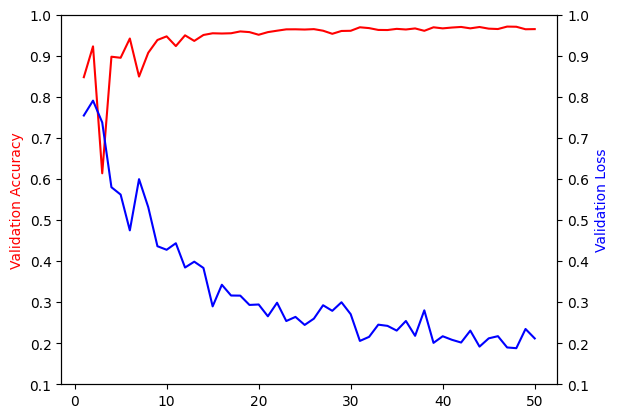

In [ ]:
# Epochs and corresponding val_loss and val_accuracy values
epochs_list = list(range(1, len(history.history['val_loss']) + 1))
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot the epoch vs val_loss
ax1 = plt.subplot(111)
ax1.plot(epochs_list, val_accuracy, 'r-')
ax1.set_ylabel('Validation Accuracy', color='r')

# Create a second y-axis for the val_accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_list, val_loss, 'b-')
ax2.set_ylabel('Validation Loss', color='b')

# Set the same scaling on the y-axes
ax1.set_ylim([0.1, 1])
ax2.set_ylim([0.1, 1])

plt.show()


In [ ]:
# Make predictions on the test images
predictions = model.predict(X_test)

# Compute the mean IoU metric on the test set
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(y_test, predictions)
print("Mean IoU on test set: {:.3f}".format(mean_iou.result()))

# Compute the precision and recall on the test set
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(y_test, predictions)
recall.update_state(y_test, predictions)

# Compute the F1 score on the test set
f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())
print("F1 score on test set: {:.3f}".format(f1_score))
print("precision on test set: {:.3f}".format(precision.result()))

#dice_coefficient=dice_coefficient(predictions, X_test)
# Reset the metrics
mean_iou.reset_states()
precision.reset_states()
recall.reset_states()

2/2 [==============================] - 16s 8ms/step
Mean IoU on test set: 0.746
F1 score on test set: 0.800
precision on test set: 0.808


1/1 [==============================] - 0s 33ms/step


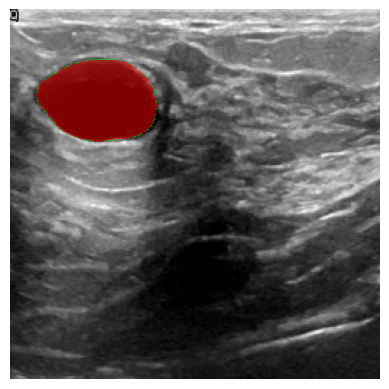

In [ ]:
image = X_test[12]
prediction = model.predict(image[None, ...])[0]
show_mask(image, prediction,cmap=newcmap)

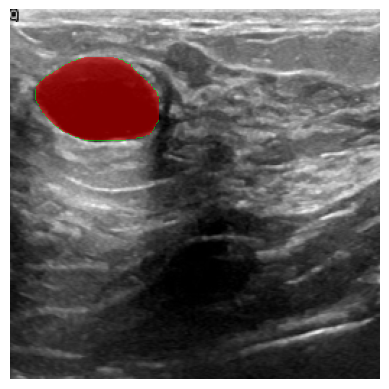

In [ ]:
show_mask(X_test[12],y_test[12],cmap=newcmap)

1/1 [==============================] - 0s 82ms/step


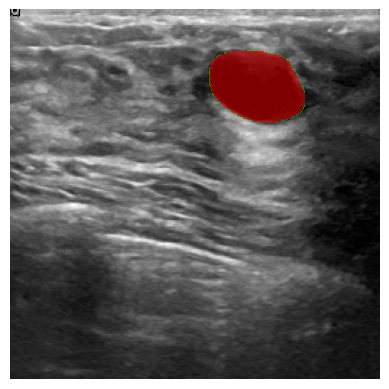

In [ ]:
image = X_test[21]
prediction = model.predict(image[None, ...])[0]
show_mask(image, prediction,cmap=newcmap)

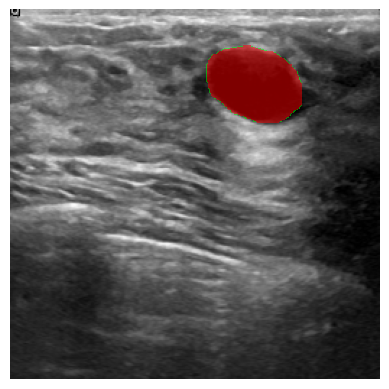

In [ ]:
show_mask(X_test[21],y_test[21],cmap=newcmap)

In [ ]:
for i in range(33):
    print(i)
    # Select an image and its true mask
    image = X_test[i]
    mask = y_test[i]

    # Make a prediction using the model
    prediction = model.predict(image[None, ...])[0]
    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    # Display the image and the model's prediction
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(prediction)
    ax2.set_title("Model Mask")

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2

# Load the segmented image
segmented_img = masks[1]
segmented_img= np.array(segmented_img, np.uint8)
# Calculate the contours of the tumor
contours, _ = cv2.findContours(segmented_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the bounding box of the tumor
x, y, w, h = cv2.boundingRect(contours[0])

# Print the width and height of the tumor
print("Tumor width:", w)
print("Tumor height:", h)

Tumor width: 78
Tumor height: 85


In [ ]:
breast = tf.keras.models.load_model(r'/content/gdrive/MyDrive/cv_project/unet_model.h5',custom_objects={'Adam':Adam},compile=False)

In [ ]:
def pred(breast_model , path):
  size = 256
  img = cv2.imread(path)
  img = img/255
  img = cv2.resize(img,(size,size))
  img_reshaped = img.reshape(1,size,size,3)

  pred_img = breast_model.predict(img_reshaped)
  pred_img = np.round(pred_img)

  plt.imshow(img)

  plt.imshow(pred_img.reshape(size,size), cmap=cmap, alpha=0.5)
  plt.axis('off')

In [ ]:
pred(breast,'Breast scans/benign/Train/benign (1).png')